## Plots for inequality analysis

M. Tsvetkova, **The effects of reputation on inequality in network cooperation games**, *Phil. Trans. B* (2021).



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sb

import os
import sys

module_path = os.path.abspath(os.path.join('../modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ineq import *
from plot import *
from concentration_library import gini

from scipy.stats import binom_test, pearsonr


### 1. Define data function

In [2]:
def get_data(dirname, tmnts, version=None):   
    
    df = pd.read_csv(os.path.join('../data/', dirname+'_data.csv'))
    
    # Treat treatments as categorical data
    df['reputation'] = df['reputation'].astype('category')
    if version != None:
        df['version'] = df['version'].astype('category')
        df = df[(df['version']==version)]
    maxround = df.groupby(['reputation', 'group']).round.max()
    groups = df.groupby('reputation').group.unique()
    
    # Print unique number of groups and unique number of participants
    print(dirname, df.group.unique().shape[0], df.player.unique().shape[0])
    
    gin = {i:[] for i in tmnts}
    coo = {i:[] for i in tmnts}
    cor = {i:[] for i in tmnts}
    for t in tmnts:
        for g in groups.loc[t]:
            subdf = df[(df.reputation==t) & (df.group==g) & (df['round']==maxround.loc[t, g])]
            if subdf.empty==False:
                gin[t].append( gini(subdf['wealth'].values) )
                pr = pearsonr(subdf['avg_action'].values, subdf['wealth'].values)[0]
                if ~np.isnan(pr):
                    cor[t].append(pr)
            subdf2 = df[(df.reputation==t) & (df.group==g)]
            if subdf2.empty==False:
                coo[t].append(np.nanmean(subdf2['action'].values)) 
    
    return [gin[i] for i in tmnts], [coo[i] for i in tmnts], [cor[i] for i in tmnts]


### 2. Define plotting functions

In [3]:
def custom_text(ax, data, x, y):
    if y=='Payo':
        ycoord = -1.24
    else:
        ycoord = -0.06
    tests = []
    for i in data:
        tests.extend(mu_test(i, reverse=False))
    for i in range(len(tests)):
        ax.text(x[i], ycoord, get_text_for_test(tests[i], precision=1, preceding0=False), fontsize=6, horizontalalignment='center')

        
def custom_axlim(ax, xlim, ylim, ylabel=None):
    if ylim=='Gini':
        ax.set_yticks([0, 0.1, 0.2, 0.3])
        ax.set_ylim(-0.07, 0.38)
    elif ylim=='Payo':
        ax.set_ylim(-1.3, 1.1)
        ax.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=0.1, dashes=[30,10])
    else:
        ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(xlim[0], xlim[1])
    if ylabel!=None: 
        ax.set_ylabel(ylabel, fontsize=6)

        
def get_legend_handles():
    rep0 = mpatches.Patch(color='1', label='reputation = 0', ec='k', lw=0.25)
    rep1 = mpatches.Patch(color='lightcoral', label='reputation = 1', ec='k', lw=0.25)
    rep3 = mpatches.Patch(color='red', label='reputation = 3', ec='k', lw=0.25)
    rep5 = mpatches.Patch(color='crimson', label='reputation = 5', ec='k', lw=0.25)
    rep6 = mpatches.Patch(color='darkred', label='reputation = 6', ec='k', lw=0.25)
    rep100 = mpatches.Patch(color='mediumvioletred', label='reputation = all', ec='k', lw=0.25)
    rep11 = mpatches.Patch(color='brown', label='reputation = 1+1', ec='k', lw=0.25)
    repavg = mpatches.Patch(color='darkviolet', label='reputation = avg', ec='k', lw=0.25)
    rep50 = mpatches.Patch(color='hotpink', label='reputation = part avg', ec='k', lw=0.25)
    repavg4 = mpatches.Patch(color='deeppink', label='reputation = last avg', ec='k', lw=0.25)
    replocavg = mpatches.Patch(color='orchid', label='reputation = local avg', ec='k', lw=0.25)
    return [rep0, rep1, rep3, rep5, rep6, rep100, rep11, repavg, rep50, repavg4, replocavg]


def plot_rep_boxplots(rand, dyn, ylabel, fname):
    
    init_plot()
    f = plt.figure(figsize=(6.5, 3.6))
    ax11 = plt.subplot2grid((2, 10), (0, 0), colspan=6)
    ax15 = plt.subplot2grid((2, 10), (0, 7), colspan=2)
    ax2  = plt.subplot2grid((2, 10), (1, 0), colspan=10)

    ### RANDOM REWIRING ###
    xlabels = ['BOLT04', 'BOLT05a', 'BOLT05b', 'SEIN06', 'STAH13', 'BAYE16a']
    xticks = [1, 2, 3, 4, 5, 6]
    positions = [0.9, 1.1, 
                 1.8, 2, 2.2, 2.8, 3, 3.2,
                 3.9, 4.1, 4.9, 5.1, 5.9, 6.1]
    colors = ['1', 'mediumvioletred', 
            '1', 'lightcoral', 'brown', '1', 'lightcoral', 'brown',
             '1', 'darkred', '1', 'lightcoral', '1', 'deeppink']

    y = [j for i in rand for j in i] 
    custom_boxplot(ax11, y, positions, colors) 
    
    # Create legend
    #ax11.legend(handles=get_legend_handles(), ncol=1, bbox_to_anchor=[1.2,0.95])

    # Add x-tick labels
    plt.setp(ax11, xticks=xticks, xticklabels=xlabels)
    custom_axlim(ax11, xlim=(0.6, 6.4), ylim=ylabel[:4], ylabel=ylabel)
    # Add test results
    x = [1, 1.85, 2.15, 2.85, 3.15, 4, 5, 6]
    custom_text(ax11, rand, x, y=ylabel[:4])
    # Add title
    ax11.set_title('A) Random rewiring')
    

    
    # LEGEND
    ax15.legend(handles=get_legend_handles(), ncol=1) #, bbox_to_anchor=[0.4, 1]
    ax15.axis('off')

    
    ### STRATEGIC UPDATING ###
    xlabels = ['CUES15', 'BAYE16b', 'BAYE16c',
               'KAME17a', 'KAME17b',
               'HARR18a', 'HARR18b',
               'MELA18a', 'MELA18b', 
               'MELA18c', 'MELA18d', 
               'MELA18e', 'MELA18f']
    xticks = list(range(1, 14))
    positions = [0.7, 0.9, 1.1, 1.3, 1.9, 2.1, 2.9, 3.1,
                 3.8, 4, 4.2, 4.8, 5, 5.2,
                 5.9, 6.1, 6.9, 7.1, 
                 7.8, 8, 8.2, 8.8, 9, 97.2,
                 9.8, 10, 10.2, 10.8, 11, 11.2,
                 11.8, 12, 12.2, 12.8, 13, 13.2]
    colors = ['1', 'lightcoral', 'red', 'crimson',
              '1', 'deeppink', '1', 'deeppink', 
              '1', 'hotpink', 'darkviolet', '1', 'hotpink', 'darkviolet',
              '1', 'darkviolet', '1', 'darkviolet', 
              '1', 'orchid', 'darkviolet', '1', 'orchid', 'darkviolet',
              '1', 'orchid', 'darkviolet', '1', 'orchid', 'darkviolet',
              '1', 'orchid', 'darkviolet', '1', 'orchid', 'darkviolet']

    y = [j for i in dyn for j in i]
    custom_boxplot(ax2, y, positions, colors) 

    # Add x-tick labels
    plt.setp(ax2, xticks=xticks, xticklabels=xlabels)
    custom_axlim(ax2, xlim=(0.3, 13.5), ylim=ylabel[:4], ylabel=ylabel)
    # Add test results
    x = [0.6, 1, 1.4, 2, 3,
         3.8, 4.2, 4.8, 5.2,
         6, 7, 
         7.8, 8.2, 8.8, 9.2,
         9.8, 10.2, 10.8, 11.2,
         11.8, 12.2, 12.8, 13.2]
    custom_text(ax2, dyn, x, y=ylabel[:4])
    # Add title
    ax2.set_title('B) Strategic updating')

    plt.tight_layout(pad=1, w_pad=0, h_pad=2)
    plt.show()
    f.savefig('../plots/'+fname+'.pdf', format='pdf', bbox_inches='tight')
    

### 3. Plot

In [4]:
# First get data
T = ['reputation = 0', 'reputation = 1']
T_B4 = ['reputation = 0', 'reputation = 100%']
T_B5 = ['reputation = 0', 'reputation = 1', 'reputation = 1+1']
T_B16 = ['reputation = 0', 'reputation = avg4']
T_C = ['reputation = 0', 'reputation = 1', 'reputation = 3', 'reputation = 5']
T_K = ['reputation = 0', 'reputation = 50%', 'reputation = 100%']
T_S = ['reputation = 0', 'reputation = 6']
T_H = ['reputation = 0', 'reputation = 100%']
T_M = ['reputation = 0', 'reputation = local', 'reputation = global']

# RANDOM REWIRING
bolt04, cbolt04, crbolt04 = get_data('bolton04', T_B4)
bolt05_a, cbolt05_a, crbolt05_a = get_data('bolton05', T_B5, version='low cost')
bolt05_b, cbolt05_b, crbolt05_b = get_data('bolton05', T_B5, version='high cost')
sein, csein, crsein = get_data('seinen', T_S)
stah, cstah, crstah = get_data('stahl', T)
baye16_a, cbaye16_a, crbaye16_a = get_data('bayer', T_B16, version='random')
g_rand = [bolt04, bolt05_a, bolt05_b, sein, stah, baye16_a]
c_rand = [cbolt04, cbolt05_a, cbolt05_b, csein, cstah, cbaye16_a]
cr_rand = [crbolt04, crbolt05_a, crbolt05_b, crsein, crstah, crbaye16_a]
    
# STRATEGIC UPDATING
cues, ccues, crcues = get_data('cuesta', T_C)
baye16_b, cbaye16_b, crbaye16_b = get_data('bayer', T_B16, version='disincentivized strategic')
baye16_c, cbaye16_c, crbaye16_c = get_data('bayer', T_B16, version='incentivized strategic')
kame_a, ckame_a, crkame_a = get_data('kamei', T_K, version='low gain')
kame_b, ckame_b, crkame_b = get_data('kamei', T_K, version='high gain')
harr_a, charr_a, crharr_a = get_data('harrell', T_H, version='mixed')
harr_b, charr_b, crharr_b = get_data('harrell', T_H, version='dynamic')
mela_a, cmela_a, crmela_a = get_data('melamed', T_M, version='non-targeted, random')
mela_b, cmela_b, crmela_b = get_data('melamed', T_M, version='non-targeted, clustered')
mela_c, cmela_c, crmela_c = get_data('melamed', T_M, version='targeted, random')
mela_d, cmela_d, crmela_d = get_data('melamed', T_M, version='targeted, clustered')
mela_e, cmela_e, crmela_e = get_data('melamed2', T_M, version='non-targeted, random')
mela_f, cmela_f, crmela_f = get_data('melamed2', T_M, version='targeted, random')
g_dyn = [cues, baye16_b, baye16_c, kame_a, kame_b, harr_a, harr_b, mela_a, mela_b, mela_c, mela_d, mela_e, mela_f]
c_dyn = [ccues, cbaye16_b, cbaye16_c, ckame_a, ckame_b, charr_a, charr_b, cmela_a, cmela_b, cmela_c, cmela_d, cmela_e, cmela_f]
cr_dyn = [crcues, crbaye16_b, crbaye16_c, crkame_a, crkame_b, crharr_a, crharr_b, crmela_a, crmela_b, crmela_c, crmela_d, crmela_e, crmela_f]


bolton04 6 16
bolton05 6 16
bolton05 6 16
seinen 8 28
stahl 4 24
bayer 4 20
cuesta 11 243
bayer 4 20
bayer 4 20
kamei 12 120
kamei 13 130
harrell 20 330
harrell 20 328
melamed 15 365


/Users/tsvetkom/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


melamed 15 393
melamed 15 363
melamed 15 384
melamed2 16 361
melamed2 14 335


GINI COEFFICIENT
-------------


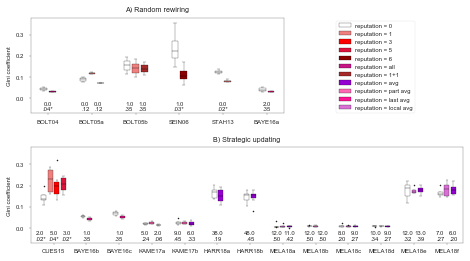

Randomly rewiring (1-sided): 0.03515625
Strategic updating (2-sided): 0.6776394844055175
Strategic updating (2-sided), without MELAa-d: 0.9999999999999997


In [5]:
print('GINI COEFFICIENT\n-------------')

# Plot inequality with Gini coefficient
plot_rep_boxplots(g_rand, g_dyn, "Gini coefficient", 'fig_3')

# Meta-analysis results
print('Randomly rewiring (1-sided):', binom_test(7, 8)/2)
print('Strategic updating (2-sided):', binom_test(10, 23))
print('Strategic updating (2-sided), without MELAa-d:', binom_test(8, 15))


CORRESPONDENCE
-------------


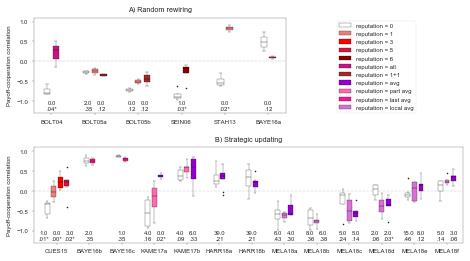

Randomly rewiring (1-sided): 0.14453124999999994
Strategic updating (1-sided): 0.33881974220275873
Strategic updating (1-sided), without MELAa-d: 0.017578125000000007


In [6]:
print('\nCORRESPONDENCE\n-------------')

# Plot inequality with correlation between payoffs and cooperativeness
plot_rep_boxplots(cr_rand, cr_dyn, "Payoff-cooperation correlation", 'fig_4')

print('Randomly rewiring (1-sided):', binom_test(6, 8)/2)
print('Strategic updating (1-sided):', binom_test(13, 23)/2)
print('Strategic updating (1-sided), without MELAa-d:', binom_test(12, 15)/2)


COOPERATION LEVEL
-------------


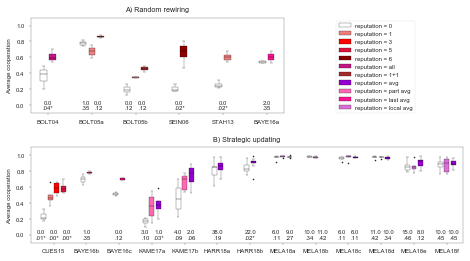

[[0.23370901960784315, 0.48278595055413465, 0.5827986633249792, 0.5903791701475912], [0.6979363425925926, 0.7824884259259259], [0.5119583333333333, 0.7023072916666666], [0.16643750000000002, 0.3568125, 0.38493749999999993], [0.4589375, 0.6617000000000001, 0.7379375], [0.810085333382264, 0.8581575197598659], [0.8426107160294972, 0.8998495670510553], [0.9695213724987232, 0.9834564325361324, 0.9828145025151521], [0.9825472677108685, 0.9775031455609924, 0.9680355496852844], [0.9593260917224724, 0.9702336594921224, 0.9786507334600086], [0.9753021558891483, 0.9725743486502394, 0.968396419015566], [0.857736258545585, 0.8608149104386058, 0.9082568225858783], [0.8855005763234898, 0.8767036471457867, 0.8961931680028922]]
Randomly rewiring (1-sided): 0.03515625
Strategic updating (1-sided): 0.0053110122680664
Strategic updating (1-sided), without MELAa-d: 0.0004882812499999999


In [8]:
print('\nCOOPERATION LEVEL\n-------------')

# Plot average cooperation level per group
plot_rep_boxplots(c_rand, c_dyn, "Average cooperation", 'fig_s2')
print([[np.mean(i) for i in j] for j in c_dyn])

print('Randomly rewiring (1-sided):', binom_test(7, 8)/2)
print('Strategic updating (1-sided):', binom_test(18, 23)/2)
print('Strategic updating (1-sided), without MELAa-d:', binom_test(14, 15)/2)